In [1]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
print(f"SpikeInterface version: {si.__version__}")
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle

from scipy.io import loadmat

SpikeInterface version: 0.102.2


In [2]:
BaseDir =  glob.glob(os.getcwd()+'/data_demo/Fabrication/flex_test_9/*')[0]
dataPath = glob.glob(BaseDir+'/*/amplifier.dat')
chanMapPath = glob.glob(BaseDir+'/chanMap.mat')[0]
display(dataPath)
display(chanMapPath)

['D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D15_Homecage_241126_000001\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D16_Homecage_241127_000002\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D17_Homecage_241128_000003\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D18_Homecage_241129_000004\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D19_Homecage_241130_000005\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D20_Homecage_241201_000006\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D21_Homecage_241202_000007\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24\\D22_homecage_241203_000008\\amplifier.dat',
 'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_te

'D:\\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\\days14to24/chanMap.mat'

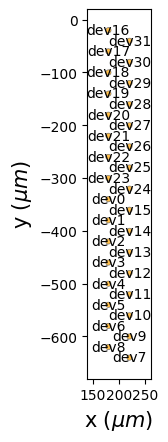

In [3]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1
ch_quality = chanMapmat['connected']
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=coords, shapes='circle',
                   shape_params={'radius': 5}, shank_ids=shank_ids)
probe.set_device_channel_indices(device_ch_inds)

probe_group = ProbeGroup()
for sid in np.unique(shank_ids):
    mask = (shank_ids == sid)              
    sub_probe = probe.get_slice(mask)      
    probe_group.add_probe(sub_probe)
plot_probegroup(probe_group, with_contact_id=True, with_device_index=True)

In [8]:
device_ch_inds[np.where(ch_quality==0)[0]]

array([ 9, 21, 22, 23, 24, 25, 26], dtype=uint8)

In [9]:
device_ch_inds[np.where(ch_quality==1)[0]]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 27, 28, 29, 30, 31], dtype=uint8)

In [10]:
fs = 20000
recording_list =[]
for i in range(len(dataPath)):
    recording_ = se.read_binary(dataPath[i], sampling_frequency=fs, dtype='int16', num_channels=32, gain_to_uV =0.195)
    # recording_ = se.read_binary(dataPath[i], sampling_frequency=fs, dtype='int16', num_channels=64)
    print(dataPath[i])
    recording_list.append(recording_)
recording = si.concatenate_recordings(recording_list)
recording = recording.set_probe(probe, group_mode='by_shank')
recording = recording.remove_channels(remove_channel_ids=device_ch_inds[np.where(ch_quality==0)[0]])

D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D15_Homecage_241126_000001\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D16_Homecage_241127_000002\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D17_Homecage_241128_000003\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D18_Homecage_241129_000004\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D19_Homecage_241130_000005\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D20_Homecage_241201_000006\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D21_Homecage_241202_000007\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D22_homecage_241203_000008\amplifier.dat
D:\SpikeSortingPipeline/data_demo/Fabrication/flex_test_9\days14to24\D23_Homecage_241204_000009\amplifier.dat


In [7]:
x, y, shank_ids, device_ch_inds

(array([180, 180, 180, 180, 180, 180, 180, 220, 180, 220, 220, 220, 220,
        220, 220, 220, 180, 180, 180, 180, 180, 180, 180, 180, 220, 220,
        220, 220, 220, 220, 220, 220], dtype=uint8),
 array([-340, -380, -420, -460, -500, -540, -580, -640, -620, -600, -560,
        -520, -480, -440, -400, -360,  -20,  -60, -100, -140, -180, -220,
        -260, -300, -320, -280, -240, -200, -160, -120,  -80,  -40],
       dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       dtype=uint8))

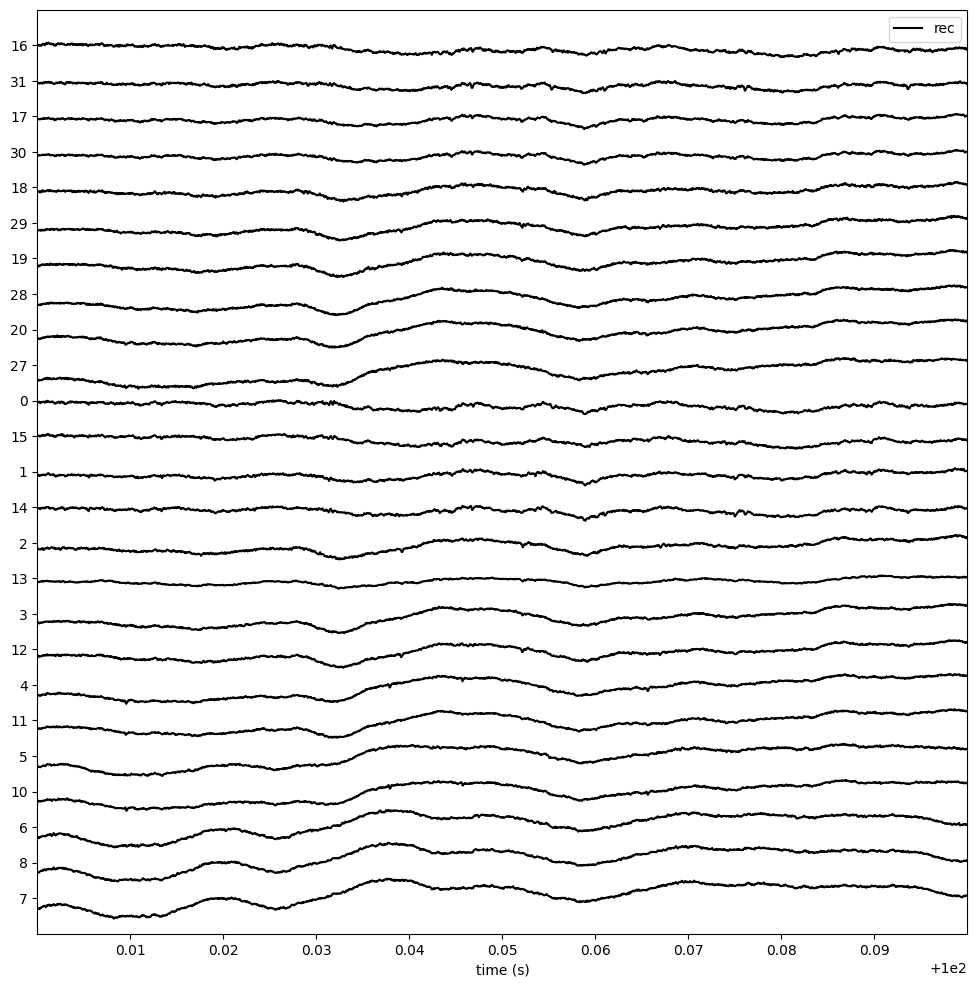

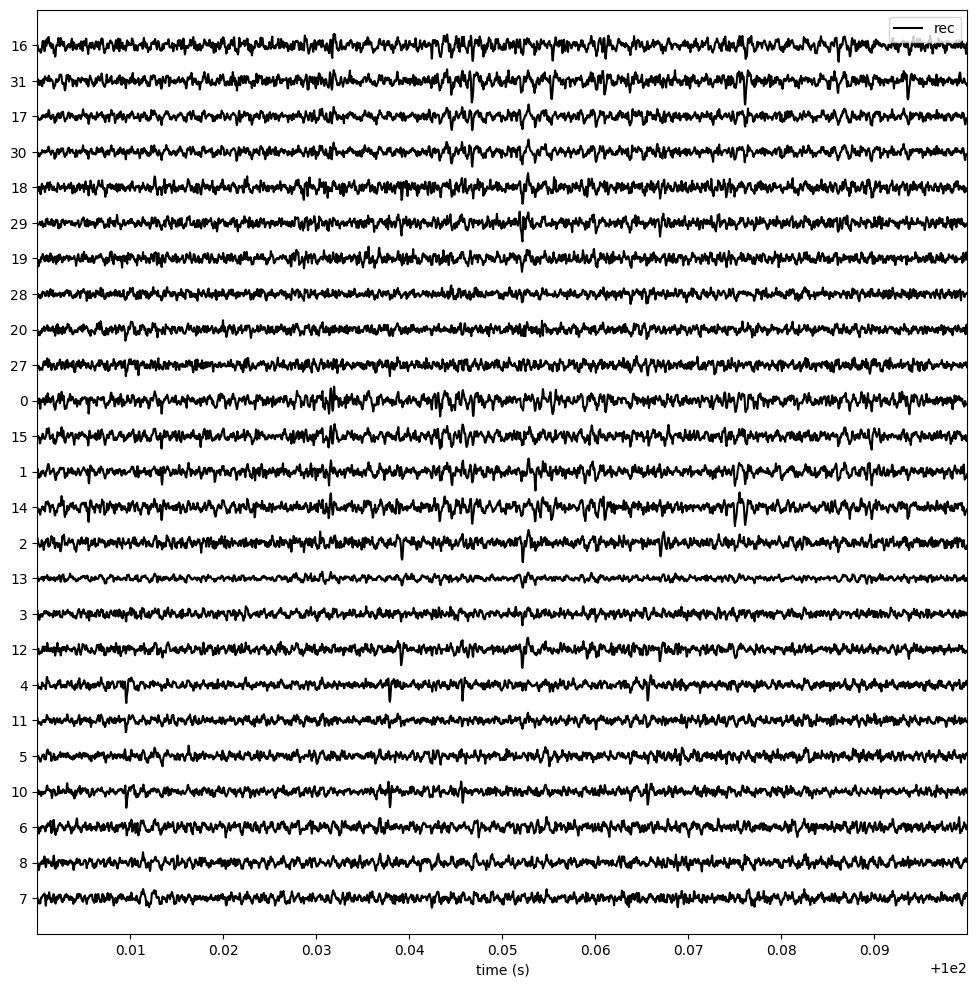

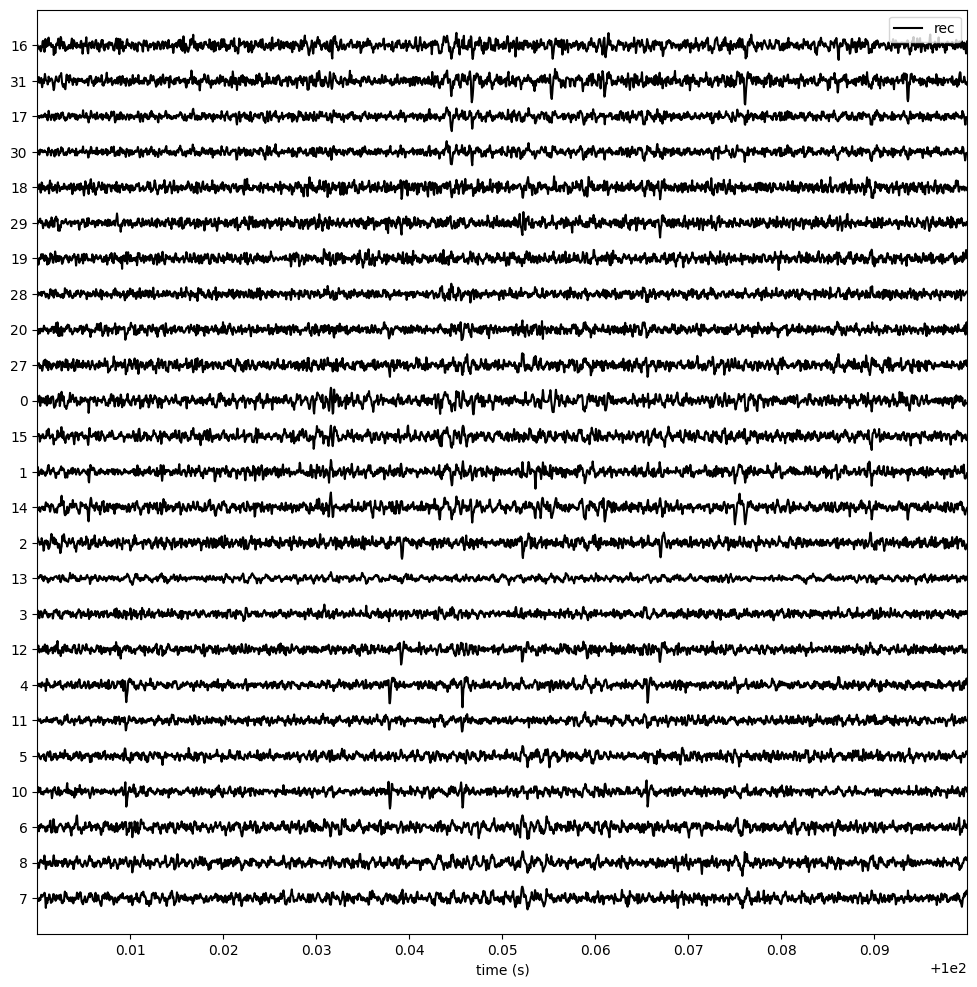

In [11]:
tmin = 100
twind = 0.1
segment_index=0
sw.plot_traces(recording, channel_ids=recording.get_channel_ids() , order_channel_by_depth=True, show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))
recording_f = spre.bandpass_filter(recording, freq_min=500, freq_max=8000)
sw.plot_traces(recording_f, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))
# recording_cmr = spre.common_reference(recording_f, reference='local', local_radius=[50,200] , operator='median')
# sw.plot_traces(recording_cmr, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))

recording_cmr = spre.common_reference(recording_f, reference='global' , operator='median')
sw.plot_traces(recording_cmr, channel_ids=recording.get_channel_ids(), order_channel_by_depth=True,show_channel_ids=True, time_range=[tmin,tmin+twind], segment_index=segment_index, color_groups=False, figsize=(12, 12))

In [12]:
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="5s", progress_bar=True)

In [13]:
preproc_path = Path(BaseDir) / "spikeinterface"
if preproc_path.is_dir():
    recording_saved = si.load(preproc_path)
else:
    recording_saved = recording_cmr.save(folder=preproc_path, **job_kwargs)

write_binary_recording 
engine=process - n_jobs=28 - samples_per_chunk=100,000 - chunk_memory=4.77 MiB - total_memory=133.51 MiB - chunk_duration=5.00s


write_binary_recording (workers: 28 processes):   0%|          | 0/24051 [00:00<?, ?it/s]

In [18]:
!python -m kilosort

2025-05-12 12:32:02,932 INFO  - FCI started. Version: 12.4.0.0

2025-05-12 12:32:02,932 INFO  - Completed loading classifications from database

2025-05-12 12:32:02,932 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Top Secret (67a1a7c8-4696-4313-a9a1-a6c81ee39902)

2025-05-12 12:32:02,933 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Confidential (b6ddc6cd-4432-4483-87f2-575d4b5247d4)

2025-05-12 12:32:02,933 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Restricted (5715afa3-e9f8-4026-9db4-92b553167095)

2025-05-12 12:32:02,933 ERROR - Unable to load classification from database with name and id (Classification icon creation failed): Public (9027971d-f9e2-411b-b70e-def3152d56aa)

2025-05-12 12:32:02,937 INFO  - Unable to monitor for Configuration updates because the endpoint service is not currently ser

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 24 or lower


In [19]:
phydir = BaseDir+'/kilosort4-2/params.py'
!phy template-gui $phydir

14:57:48.979 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.


In [18]:
sorting_phy = se.PhySortingExtractor(BaseDir+'/preprocessed/kilosort4', exclude_cluster_groups=['noise', 'mua'])
# sorting_phy_KS1 = se.PhySortingExtractor(BaseDir+'/Kilosort_2025-04-24_175843_YS', exclude_cluster_groups=['noise', 'mua'])

unit ids : [ 0 36 50 51 52 53 54 64 67]
unit number : 9


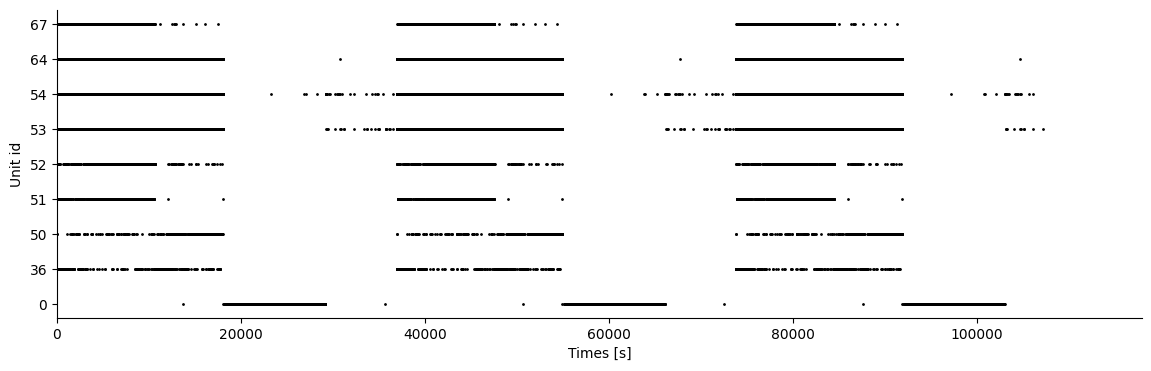

In [19]:
fig=plt.figure(figsize=(14,4))
sw.plot_rasters(sorting_phy, color='k', figure=fig, ax=None);
print(f'unit ids : {sorting_phy.get_unit_ids()}')
print(f'unit number : {len(sorting_phy.get_unit_ids())}')